# Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import cmocean

from shapely.geometry import Polygon, Point
import shapely 

# Plotting Functions

In [2]:
maxLinearPlotPoints = 200

font = {'family' : 'DejaVu Sans',
    'weight' : 'normal',
    'size'   : 14}

matplotlib.rc('font', **font)

# Code courtesy of Chris Williams, http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))   
      
def pcolorAutoScale( ax ,x, y , data, cmap, vMin=None, vMax=None):
    
    if (vMax == None):    
        vMax = np.max( data )
    if (vMin == None):
        vMin = np.min( data )

    return ax.pcolor(x, y, data, cmap=cmap, vmin=vMin, vmax=vMax, norm=MidpointNormalize(midpoint=0,vmin=vMin, vmax=vMax) )

def plotBathy( ax, x, y, z , stride=1):
    
    def getLength(s):
        sMax = np.max(s)
        sMin = np.min(s)
        sL = sMax - sMin 
        return sL 
    
    cmBathy = cmocean.cm.topo 
    cmBathyContour = cmocean.cm.matter

    maxLen = 12
    
    xL = getLength(x)
    yL = getLength(y) 

    cp = pcolorAutoScale(ax,x[::stride],y[::stride],z[::stride,::stride],cmBathy )
    
    if ( xL > yL ):
        cb = fig.colorbar(cp , ax=ax, orientation='horizontal')
    else:
        cb = fig.colorbar(cp , ax=ax, orientation='vertical')
        
    cb.set_label('Topology/Bathymetry (m)')

    ax.set_aspect('equal', 'box')
    
    CS = ax.contour(x , y, z, 10, cmap=cmBathyContour )
    plt.clabel(CS, inline=1, fontsize=14)
    
    ax.set_xlabel( "x (m)")    
    ax.set_ylabel( "y (m)")

# Simple Bathy Example
## Generate a simple bathmetry/topography 

Grid Dimensions: nGlob=500, mGlob=600, stride=3
Plot Dimensions: nGlob=166, mGlob=200


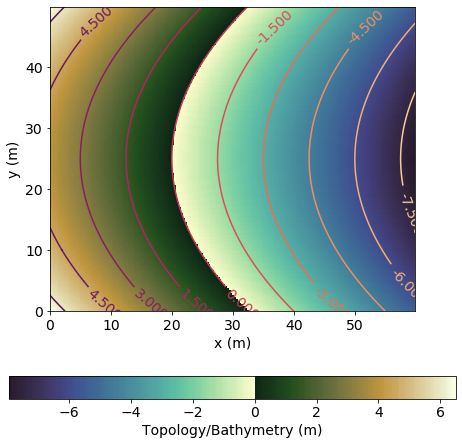

In [3]:
x0 = 0
y0 = 0

dx = 1/10
dy = 1/10

nGlob = 50*10
mGlob = (2.5*200+100)

# Constructing equispaced grid  
x = np.arange(0,mGlob)*dx + x0
y = np.arange(0,nGlob)*dy + y0

# Computing stride based on max linear plot size
nMax = max(nGlob,mGlob)
stride = int(nMax/maxLinearPlotPoints)
if ( stride < 1 ): stride = 1
    
nGlobPlot = int( nGlob/stride )
mGlobPlot = int( mGlob/stride )
    
[X,Y] = np.meshgrid(x,y)

# Simple bathy/topo of a sloping beach with slope 0.2 and zero contour line at x=25
bathy = 0.2*(25-X) + 0.004*(Y-25)**2-1

print( "Grid Dimensions: nGlob=%d, mGlob=%d, stride=%d" % (nGlob, mGlob, stride) )
print( "Plot Dimensions: nGlob=%d, mGlob=%d" % (nGlobPlot,mGlobPlot) )

# Plotting topography/bathymetry
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)


plotBathy( ax, x, y, bathy, stride )

# Loading data and building grid
## Read in bathymetry/topography FUNWAVE ASCII file

In [ ]:
# File path/name
bathyFilePath = 'testBathy.txt'

# Origin point of grid
x0 = 0
y0 = 0

# Grid Resolution
dx = 0.1
dy = 2

# Maximum number of points to plot in a single direction 

# Loading data
funwaveBathy = np.loadtxt(bathyFilePath) 

# Reversing FUNWAVE sign change, easier to work with
bathy = -funwaveBathy
[nGlob, mGlob] = funwaveBathy.shape

# Constructing equispaced grid  
x = np.arange(0,mGlob)*dx + x0
y = np.arange(0,nGlob)*dy + y0

# Computing stride based on max linear plot size
nMax = max(nGlob,mGlob)
stride = int(nMax/maxLinearPlotPoints)
if ( stride < 1 ): stride = 1
    
nGlobPlot = int( nGlob/stride )
mGlobPlot = int( mGlob/stride )

print( "Grid Dimensions: nGlob=%d, mGlob=%d, stride=%d" % (nGlob, mGlob, stride) )
print( "Plot Dimensions: nGlob=%d, mGlob=%d" % (nGlobPlot,mGlobPlot) )

# Plotting topography/bathymetry
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)


plotBathy( ax, x, y, bathy, stride )

# Breakwater Functions

In [4]:
def getPrism( x0, y0, x, y, length, baseWidth, height, topWidthStartRel, mBack, cBack, topWidthEndRel, mFront, cFront, angle, angleRot, bottomBathy ):

    [X,Y] = np.meshgrid(x,y)
    
    U = (X-x0)*np.cos(-angleRot) - (Y-y0)*np.sin(-angleRot)
    V = (X-x0)*np.sin(-angleRot) + (Y-y0)*np.cos(-angleRot)
    
    sol = U*0

    idxV = ( -length/2 < V  ) & ( V < length/2 )
    
    idxU = ( -baseWidth/2 <= U ) & ( U <= topWidthStartRel )
    idx = idxV * idxU
    sol[idx] = mBack*U[idx] + cBack
    
    idxU = ( topWidthStartRel <= U ) & ( U <= topWidthEndRel )
    idx = idxV * idxU    
    sol[idx] = height
    
    idxU = ( topWidthEndRel <= U ) & ( U <= baseWidth/2 )
    idx = idxV * idxU    
    sol[idx] = mFront*U[idx] + cFront
    
    sol = np.minimum( sol , height  ) 
    sol = np.maximum( sol , bottomBathy )
     
    return sol

def getBaseShape( width , length, angleRot, x0, y0 ):
    # Vertices of bottom of breakwater 
    vetrices = [
        ( -width/2, -length/2 ),
        (  width/2, -length/2 ),
        (  width/2,  length/2 ),
        ( -width/2,  length/2 )
    ]

    baseShape       = Polygon( vetrices )
    rotShape        = shapely.affinity.rotate(baseShape, angleRot , origin='center', use_radians=True)
    shiftedRotShape = shapely.affinity.translate(rotShape, xoff=x0, yoff=y0, zoff=0.0 )
    
    return shiftedRotShape

def getBasePoints( shape , x , y ):
    
    print('Start')
    idxs = [] 
    # Extracting indices or points in array
    for j in range(len(y)):

        for i in range(len(x)):

            pt = Point( ( x[i] , y[j])  )

            if shape.contains( pt ):
            #if shape.contains( pt ):
                idxs.append( (j,i) )

    # Converting from list of tuples indices, (j,i), to tuple 
    # of arrays, i.e, [ (j_0,i_0), (j_1,i_1), ..., (j_n,i_n) ] =>
    #                 ( [j_0,j_1,...,j_n], [i_0,i_1,...,i_n] )
    idxs = tuple(np.array(idxs).T)
    
    print('End')
    return idxs

def addBreakWater( breakwater, bathy ):

    nX = len(breakwater['x'])
    nY = len(breakwater['y'])

    n = nX
    
    corners = []
    
    for i in range(n-1):
        
        print( '      Adding section %d' % (i+1) )
        
        x1 = breakwater['x'][i]
        x2 = breakwater['x'][i+1]
        y1 = breakwater['y'][i]
        y2 = breakwater['y'][i+1]
        bathy, angleRot, topWidth, slope = addBreakWaterSub( x1, y1, x2, y2, breakwater, bathy )
        
        corners.append( ( angleRot, topWidth, slope) )
    
    nC = len(corners)
    for i in range(nC-1):
        
        print( '      Adding corner %d' % (i+1) )
        
        startAngle, topWidth1, slope1 = corners[i]
        endAngle  , topWidth2, slope2 = corners[i+1] 
        
        x0 = breakwater['x'][i+1]
        y0 = breakwater['y'][i+1]
        heightAboveWater = breakwater['heightAboveWater']
        slope = ( slope1 + slope2)/2
        topWidth = (topWidth1 + topWidth2)/4
             
        addCornerBreakwater( x0, y0, topWidth, heightAboveWater, slope, startAngle, endAngle, bathy)
        
def addBreakWaterSub( x1, y1, x2, y2, breakwater, bathy ):
    
    angle = np.arctan2( y2 - y1 , x2 - x1)
    angleRot = angle - np.pi/2 
    length = ((x2-x1)**2 + (y2-y1)**2)**0.5
    x0 = x1 + np.cos(angle)*length/2
    y0 = y1 + np.sin(angle)*length/2
    
    if 'angle' in breakwater.keys(): 
        print( '         Using parameter angle')
        angleFront = breakwater['angle']*np.pi/180
        angleBack= breakwater['angle']*np.pi/180
        
        isAngleDef = True
        
    elif 'angleFront' in breakwater.keys() or 'angleBack' in breakwater.keys():  
        print( '         Using parameters angleFront and angleBack')
        
        if 'angleFront' in breakwater.keys() and 'angleBack' in breakwater.keys():
            angleFront = breakwater['angleFront']*np.pi/180
            angleBack = breakwater['angleBack']*np.pi/180            
        elif 'angleFront' in breakwater.keys():
            print( '            WARNING: angleBack not defined, setting angleFront to angleBack')
            angleFront = breakwater['angleFront']*np.pi/180
            angleBack = angleFront
        else:
            print( '            WARNING: angleFront not defined, setting angleFront to angleBack')
            angleBack = breakwater['angleBack']*np.pi/180
            angleFront = angleBack
            
        isAngleDef = True
        
    elif 'bottomWidth' in breakwater.keys() and 'topWidth' in breakwater.keys():
        print( '         Using parameters bottomWidth and topWidth')
        
        bottomWidth = breakwater['bottomWidth'] 
        topWidth = breakwater['topWidth'] 

        isAngleDef = False
        
    else:
        raise Exception("Additional parameters not fully defined")
    
    def getHeight( bottomWidth ):
        baseShape = getBaseShape( bottomWidth , length, angleRot, x0, y0  )
        
        minX, minY, maxX, maxY = baseShape.bounds
        
        idxX = np.where(( minX <= x ) & ( x <= maxX ))[0]
        idxY = np.where(( minY <= y ) & ( y <= maxY ))[0]
        
        iXS = idxX.min()
        iXE = idxX.max()
        iYS = idxY.min()
        iYE = idxY.max()
        
        subX = x[iXS:iXE]
        subY = y[iYS:iYE]
        
        subBathy = bathy[iYS:iYE,iXS:iXE]

        minDepth = np.min( subBathy )
        #minDepth = np.min( subBathy[idxs] )
        height = breakwater['heightAboveWater'] - minDepth           
        return baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy
  
    if isAngleDef:
        if 'bottomWidth' in breakwater.keys():
            print( '         Using parameter bottomWidth')
            bottomWidth = breakwater['bottomWidth']  

            baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeight( bottomWidth ) 

        elif 'midWidth' in breakwater.keys(): 
            print( '         Using parameter midWidth')

            midWidth = breakwater['midWidth']
            bottomWidth = midWidth          
            dBottomWidth = bottomWidth

            for i in range(0,10): 
                baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeight( bottomWidth ) 

                frontWidth = 0.5*height/np.tan(angleFront)            
                backWidth = 0.5*height/np.tan(angleBack)

                tmpBottomWidth = midWidth + frontWidth + backWidth
                dBottomWidth = tmpBottomWidth - bottomWidth
                bottomWidth = tmpBottomWidth

                error = abs(dBottomWidth)/bottomWidth


                if (error < 10**-6 ):
                    baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeight( bottomWidth )
                    break


        elif 'topWidth' in breakwater.keys():          
            print( '         Using parameter topWidth')        
            topWidth = breakwater['topWidth']
            bottomWidth = 5*topWidth          
            dBottomWidth = bottomWidth

            for i in range(0,10): 
                baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeight( bottomWidth ) 

                frontWidth = height/np.tan(angleFront)            
                backWidth = height/np.tan(angleBack)

                tmpBottomWidth = topWidth + frontWidth + backWidth
                dBottomWidth = tmpBottomWidth - bottomWidth
                bottomWidth = tmpBottomWidth

                error = abs(dBottomWidth)/bottomWidth

                if (error < 10**-6 ):
                    baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeight( bottomWidth )
                    break

        else:
            raise Exception("Reference width defined")
    else:
        toeLength = (bottomWidth - topWidth)/2
        baseShape, height, idxs, minDepth = getHeight( bottomWidth ) 
        
        angleFront = np.arctan(height/toeLength)
        angleBack = angleFront

    frontWidth = height/np.tan(angleFront)            
    backWidth = height/np.tan(angleBack)
    topWidth = bottomWidth - (frontWidth+backWidth)
    topWidthStartRel = -bottomWidth/2 + backWidth
    topWidthEndRel = bottomWidth/2 - frontWidth

    if topWidth <= 0:
        raise Exception( 'Width at the top of the break water is negative, either decrease slope angle or increase reference width')

    mBack = height/backWidth
    cBack = (height*bottomWidth )/(2*backWidth)
    
    if abs(mBack) > 1:
        print('         WARNING: Slope behind the breakwater is greater than 1 and may cause instabilities in FUNWAVE' )
    
    mFront = -height/frontWidth
    cFront = (height*bottomWidth )/(2*frontWidth)   
    
    if abs(mFront) > 1:
        print('         WARNING: Slope in front of the breakwater is greater than 1 and may cause instabilities in FUNWAVE' )
    
    if ( height > 0 ):

        bottomBathy = subBathy- minDepth
        subBathy = minDepth
        subBathy += getPrism( x0, y0, subX, subY, length, bottomWidth, height, topWidthStartRel, mBack, cBack, topWidthEndRel, mFront, cFront, angle, angleRot, bottomBathy )
        
        bathy[iYS:iYE,iXS:iXE] = subBathy
    else:
        raise Exception('Height of breakwater above sea floor is negative, either change to position of the breakwater or increase the height above water level.' )
        
        
    return bathy, angleRot, topWidth, abs(mBack)

def getBaseShapeCorner( length,  startAngle, endAngle, x0, y0 ):
    # Vertices of bottom of breakwater 
    vetrices = [
        ( 0, 0 ),
        ( length*np.cos(startAngle), length*np.sin(startAngle) ),
        ( length*np.cos(endAngle)  , length*np.sin(endAngle)   )
    ]

    baseShape       = Polygon( vetrices )
    shiftedShape = shapely.affinity.translate(baseShape, xoff=x0, yoff=y0, zoff=0.0 )
    
    return shiftedShape


def getHeightCorner(  x0, y0, bottomWidth, heightAboveWater,  startAngle, endAngle, bathy ):
    
    baseShape = getBaseShapeCorner( bottomWidth,  startAngle, endAngle, x0, y0 )
    
    minX, minY, maxX, maxY = baseShape.bounds

    idxX = np.where(( minX <= x ) & ( x <= maxX ))[0]
    idxY = np.where(( minY <= y ) & ( y <= maxY ))[0]

    iXS = idxX.min()
    iXE = idxX.max()
    iYS = idxY.min()
    iYE = idxY.max()

    subX = x[iXS:iXE]
    subY = y[iYS:iYE]

    subBathy = bathy[iYS:iYE,iXS:iXE]

    minDepth = np.min( subBathy )
        
    height = heightAboveWater - minDepth           

    return baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy
    
def getCorner( x0, y0, x, y, height, topWidth, slope, startAngle, endAngle, bottomBathy ):
    
    angleRot = startAngle

    theta1 = endAngle - startAngle
    theta2 = (np.pi - theta1)/2
    
    [X,Y] = np.meshgrid(x,y)

    U = (X-x0)*np.cos(-angleRot) - (Y-y0)*np.sin(-angleRot)
    V = (X-x0)*np.sin(-angleRot) + (Y-y0)*np.cos(-angleRot)

    alpha = np.arctan2(V,U)
    gamma = theta2 
    beta = np.pi - gamma - alpha
    c = np.sqrt(U**2 + V**2)
    b = c*np.sin(beta)/np.sin(gamma)

    sol = U*0
    
    dt = theta1*0.01
    idxA = ( -dt <= alpha ) & ( alpha <= theta1 + dt ) 
    
    idxs = ( ( b<=topWidth ) & idxA ) 
    sol[idxs] = height
    
    idxs = ( ( b>=topWidth ) &  idxA )
    sol[idxs] = height-slope*(b[idxs]-topWidth)
    
    
    sol = np.minimum( sol , height  ) 
    sol = np.maximum( sol , bottomBathy )
    
    return sol


def addCornerBreakwater( x0, y0, topWidth, heightAboveWater, slope, startAngle, endAngle, bathy):
    
    bottomWidth = 5*topWidth
    angleSlope = np.arctan(slope)
    for i in range(10):


        baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeightCorner(x0, y0,  bottomWidth, heightAboveWater,  startAngle, endAngle, bathy )

        newBottomWidth = topWidth  + height/np.tan(angleSlope)    

        dBottomWidth = newBottomWidth - bottomWidth
        bottomWidth = newBottomWidth
        error = abs(dBottomWidth)/bottomWidth
        
        if (error < 10**-6 ):
            baseShape, height, minDepth, iXS, iXE, iYS, iYE, subX, subY, subBathy = getHeightCorner(x0, y0,  bottomWidth, heightAboveWater,  startAngle, endAngle, bathy )
            break    

    bottomBathy = subBathy - minDepth
    subBathy = minDepth

    subBathy += getCorner( x0, y0, subX, subY, height, topWidth, slope, startAngle, endAngle, bottomBathy )

    bathy[iYS:iYE,iXS:iXE] = subBathy

# Adding breakwater to bathy 
<ol>
    <li> Multiple break waters can be added by created seperated dictionary for each break water and adding them to a list </li>
    <li> Breakwater can be defined in to main ways: through the top and bottom width of the breakwater, or through  slope angle(s)  and some reference width </li>
 </ol>
 
## The required parameters for either methods are:
<ol>
    <li> x - list of x coordinates of the breakwater </li>
    <li> y - list of y coordinates of the breakwater </li>
    <ul>
        <li>3 order more coordinates indicated connected breakwater segments</li>
    </ul>
    <li> heightAboveWater - to height of the breakwater above sea level (negative values for submerged breakwaters) </li>
 </ol>
 
## To define the breakwater through slope angle(s) the additional parameters are:
<ol>
    <li> The slope angle(s) which is/are either: </li>
    <ol>
        <li> A single slope angle 
            <ul>   
                <li> angle - the slope angle in front and back of the breakwater </li>
            </ul>   
        </li>
        <li> or two slope angles
            <ul>   
                <li> angleFront - the angle in front of the breakwater  </li>
                <li> angleBack - the angle in behind of the breakwater  </li>
            </ul>   
        </li>
    </ol>
    <li> and a reference width which is either: </li>
    <ol>
        <li> topWidth - the width at the top of the breakwater </li>
        <li> midWidth - the width at the middle of the breakwater (or average width of a flat bathymetry) </li>
        <li> bottomWidth - the width at the bottom of the breakwater </li>
    </ol>
</ol>
  
## To define the breakwater the top and bottom width of the breakwater the additional parameters are:
<ol>
    <li> topWidth - the width at the top of the breakwater </li>
    <li> bottomWidth - the width at the bottom of the breakwater </li>
</ol>


### Notes
<ul>
    <li> The order in which additional parameters are check for are: </li>
    <ul>
        <li> angle </li>
        <li> angleFront and angleBack </li>
        <li> topWdith and bottomWidth </li>
    </ul>
    and the breakwater will be genereated using the first parameter(s) that is/are found
    <li> If only angleFront or angleBack are defined, the undefined parameter will be set to the defined parameter, i.e., defaults to the angle method </li>
    <li> For the angle(s) methods, the reference widths will be checked in the following order </li>
    <ul>
        <li> bottomWidth </li>
        <li> midWidth </li>
        <li> topWidth </li>
    </ul>
    and the breakwater will be genereated using the first parameter that is found
</ul>

In [ ]:
breakWater1 = {
    'x'              : [30, 40, 30],
    'y'              : [5, 25, 45],
    "heightAboveWater": 2,
    "topWidth"        : 2,
    'angle'           : 40
#    'angleFront'      : 20,
#    'angleBack'       : 60
}


# Adding breakwater dicts to a list 
breakWaters = [ breakWater1 ]

# Copying original bathy to seperate varible 
bathyBreakwaters = bathy.copy()

# Adding breakwater(s) to bathy 
nB = len(breakWaters)
print( 'Adding %d breakwater(s) to bathymetry/topography' % nB )

for i, breakwater in zip(range(nB),breakWaters):

    print( '   Breakwater %d' % (i+1) )
    addBreakWater( breakwater, bathyBreakwaters )


fig, axs = plt.subplots(1,2)
fig.set_size_inches(20, 20)
axs=axs.flatten()
plotBathy( axs[0], x, y, bathy, stride )
plotBathy( axs[1], x, y, bathyBreakwaters, stride )


Adding 1 breakwater(s) to bathymetry/topography
   Breakwater 1
      Adding section 1
         Using parameter angle
         Using parameter topWidth
      Adding section 2
         Using parameter angle
         Using parameter topWidth
      Adding corner 1


# Saving FUNWAVE Bathy File

In [ ]:
outputFilePath = 'bathyBreakwaters.txt'
funwaveBathyBreakwaters= -bathyBreakwaters

np.savetxt( outputFilePath, funwaveBathyBreakwaters)